# Cost-Complexity Pruning (CCP) – Post-Pruning in Decision Trees

## 1. The basic idea of post-pruning

Grow a **maximally large tree** first → then **remove** (prune) parts that are not helpful for generalization

Two main philosophies exist:

| Method              | When pruning happens          | Most common implementation     | Used in libraries       |
|---------------------|-------------------------------|--------------------------------|--------------------------|
| Pre-pruning         | during tree growth            | stop criteria (max_depth, min_samples_leaf, …) | scikit-learn (default)  |
| Post-pruning        | after full tree is grown      | Cost-Complexity Pruning (CCP)  | scikit-learn, CART      |

CCP = the most popular **post-pruning** method (introduced in CART, 1984)

## 2. Core concept: Cost-Complexity measure

We want to find a good trade-off between:

- How well the tree fits the **training data** (low error)
- How **simple** the tree is (few leaves / small tree)

This trade-off is controlled by a single parameter **α** (alpha).

The cost-complexity of a tree T is defined as:

**R_α(T) = R(T) + α × |T|**

Where:

| Symbol     | Meaning                                          | Typical name                     |
|------------|--------------------------------------------------|----------------------------------|
| R(T)       | Misclassification error rate on **training** data | Resubstitution error             |
| |T|        | Number of terminal nodes (leaves)                | Tree size / complexity           |
| α          | Complexity penalty parameter (≥ 0)               | Regularization strength          |
| R_α(T)     | Cost-complexity measure                          | Effective cost                   |

- **α = 0** → we only care about error → → → full / unpruned tree  
- **α → ∞** → we heavily penalize complexity → → → tree with 1 node (stump)

## 3. How CCP actually works – step by step

1. Grow the **largest possible tree** T₀  
   (no restrictions except purity or min_samples_split=2, min_samples_leaf=1)

2. For each internal node, compute the **weakest link**  
   → the branch that gives the smallest increase in error per removed leaf

   Define the **effective α** for a node:

   α_effective = (R_branch − R_children) / ( |T_children| − 1 )

   The smallest such α among all nodes is the first pruning step.

3. Prune the subtree with the **smallest effective α**  
   → replace that subtree with a leaf  
   → this gives a new (smaller) tree T₁

4. Repeat the process on the new tree → get T₂, T₃, … until only root remains

5. This process produces a **sequence of nested trees**:

   T₀ ⊃ T₁ ⊃ T₂ ⊃ … ⊃ T_last (just root)

   Each tree corresponds to one **effective α value** (increasing sequence)

6. Choose the “best” tree among them using:

   - separate **validation set**
   - **cross-validation** (most common in practice)
   - 1-SE rule (conservative choice – Breiman et al.)

## 4. How scikit-learn implements it

```python
# Step A: grow full tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

# Step B: compute the entire pruning path in one go
path = tree.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas          # increasing alphas
impurities = path.impurities          # R(T) + alpha * |T|

Train: 105 samples | Test: 45 samples

Full tree (α = 0.0):
  depth = 5, leaves = 8
  train = 1.0000 | test = 0.9333

α      depth  leaves  train    test     comment
-------------------------------------------------------
0.000       5        8   1.0000  0.9333  original / unpruned
0.009       3        4   0.9810  0.9333  light pruning
0.019       2        3   0.9714  0.8889  moderate / strong pruning
0.250       2        3   0.9714  0.8889  moderate / strong pruning


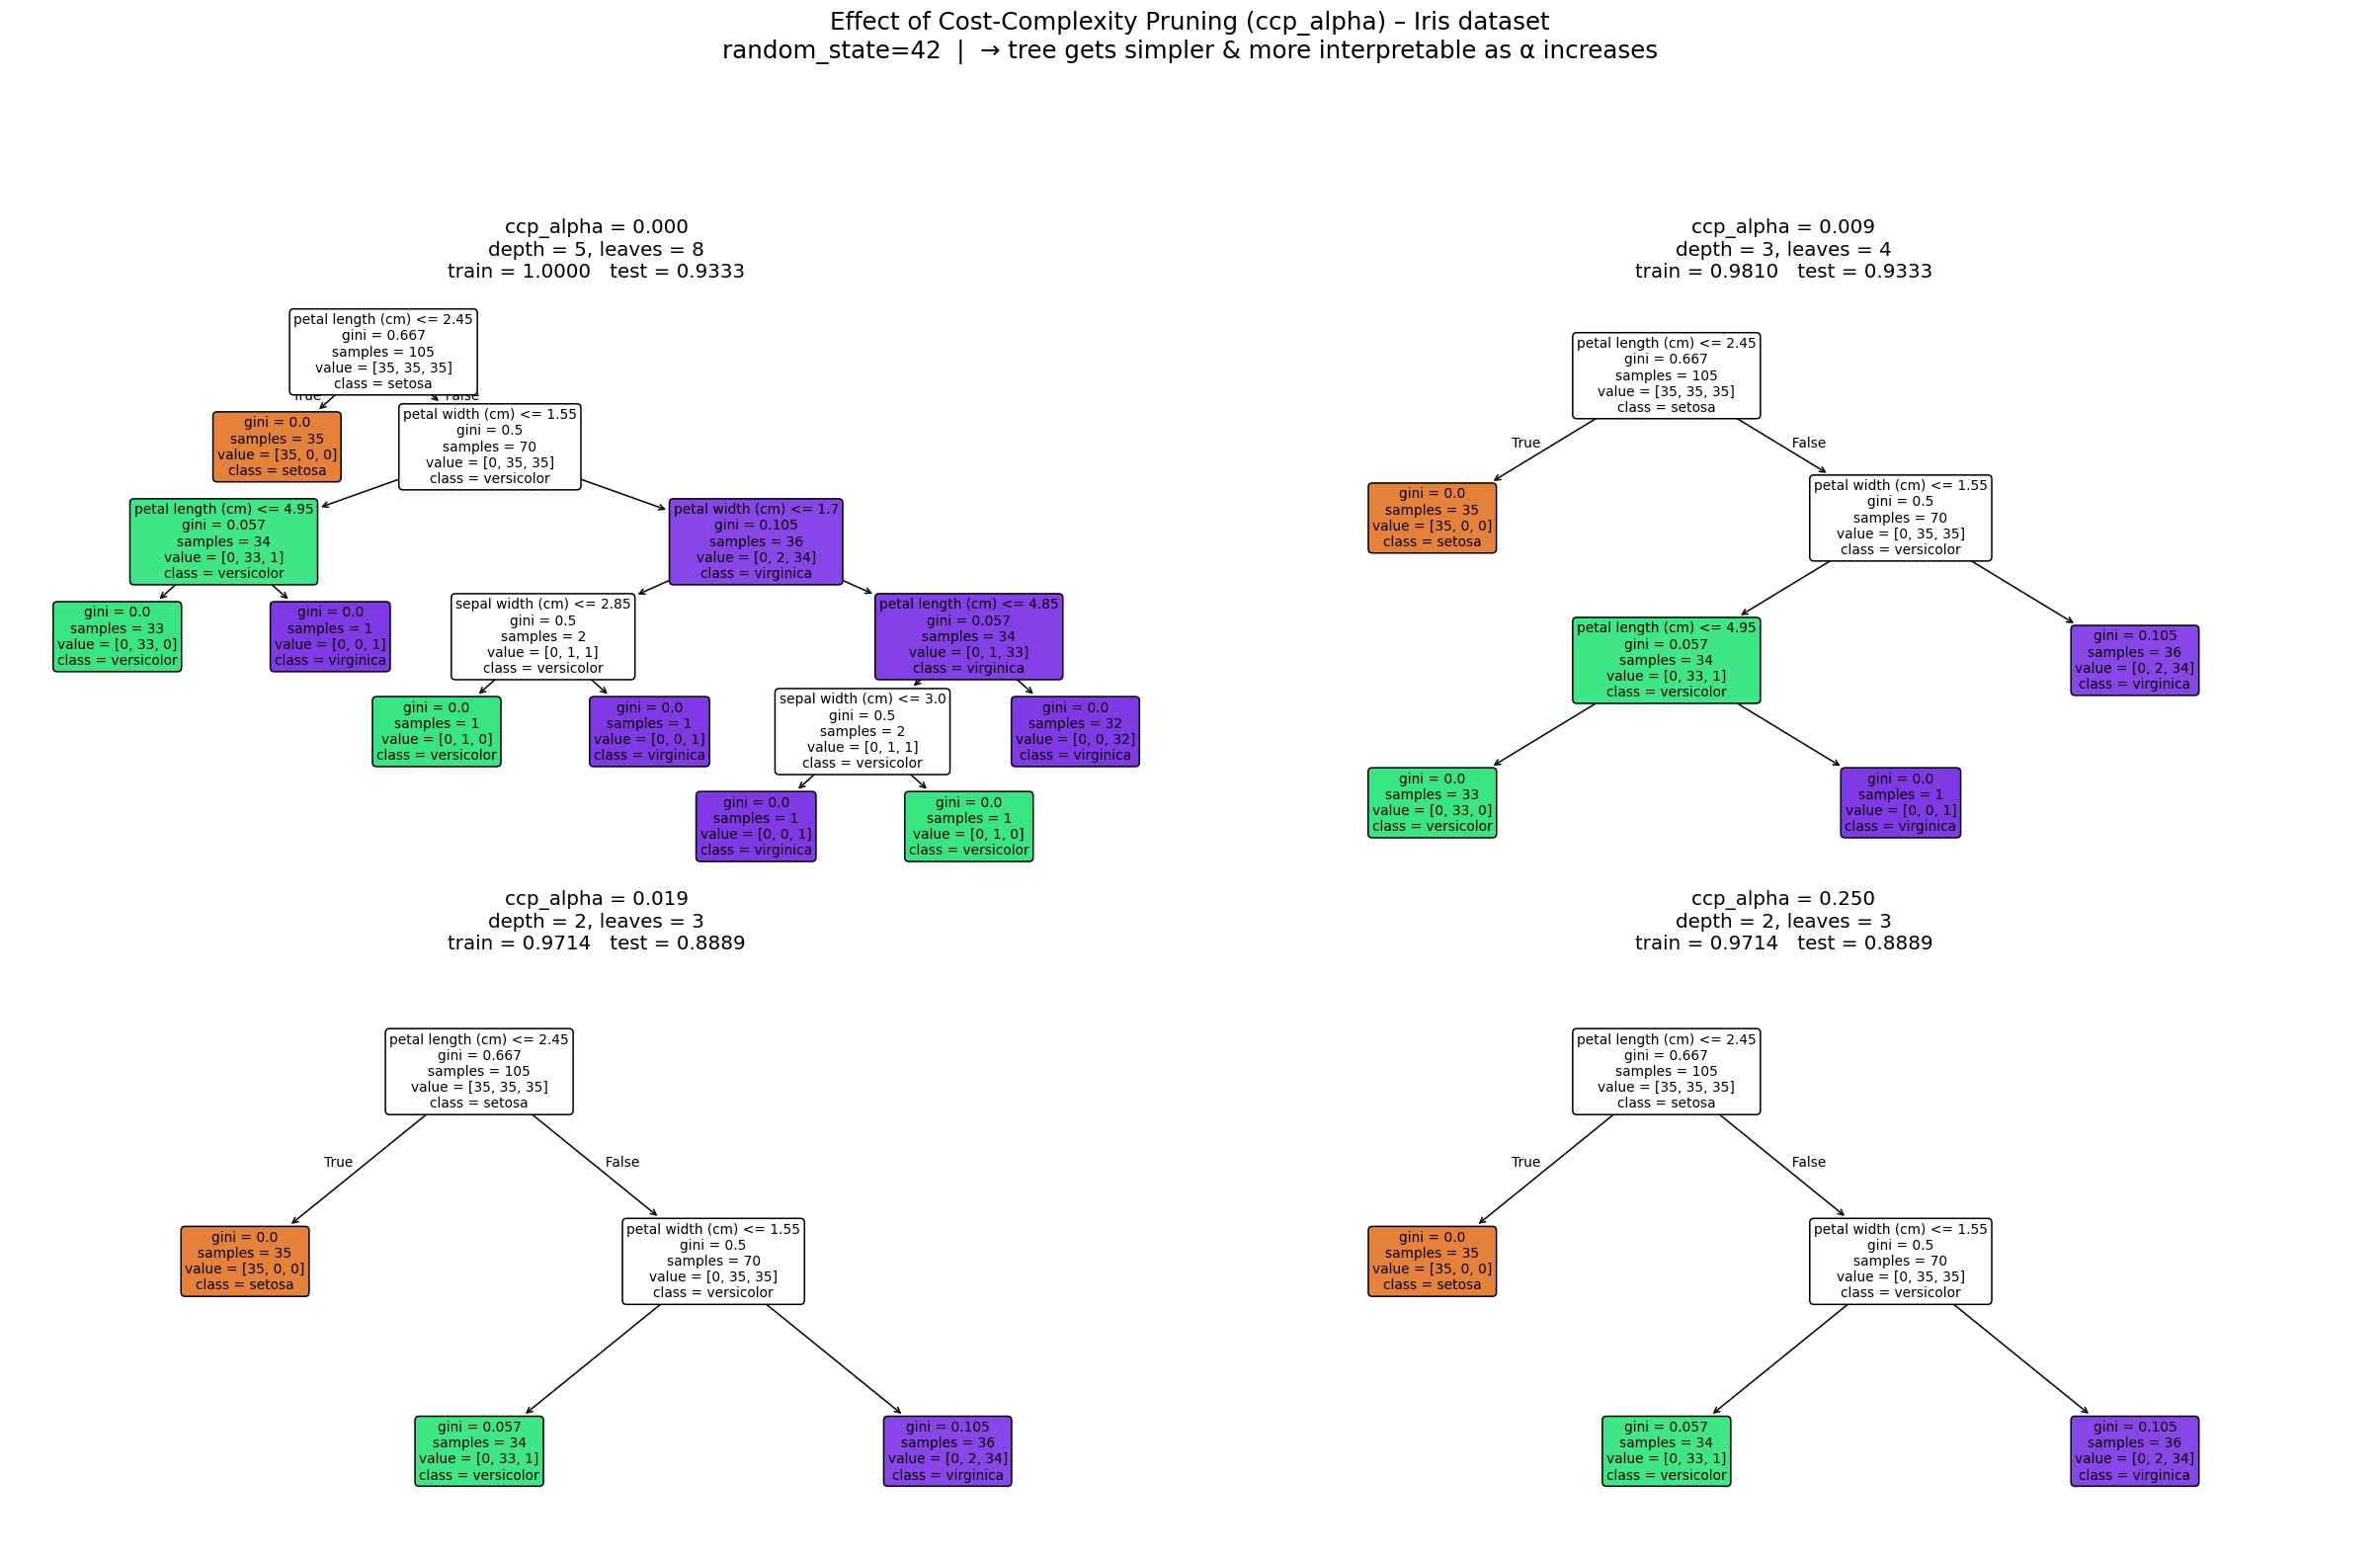

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

# ── Data ─────────────────────────────────────────────────────────
iris = load_iris()
X, y = iris.data, iris.target
feature_names = iris.feature_names
class_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]} samples | Test: {X_test.shape[0]} samples\n")

# ── Full unpruned tree ──────────────────────────────────────────
tree_full = DecisionTreeClassifier(random_state=42, ccp_alpha=0.0)
tree_full.fit(X_train, y_train)

acc_train_full = accuracy_score(y_train, tree_full.predict(X_train))
acc_test_full  = accuracy_score(y_test,  tree_full.predict(X_test))

print("Full tree (α = 0.0):")
print(f"  depth = {tree_full.get_depth()}, leaves = {tree_full.get_n_leaves()}")
print(f"  train = {acc_train_full:.4f} | test = {acc_test_full:.4f}\n")

# ── Three alpha values from your previous run ───────────────────
alphas_to_show = [0.000, 0.009, 0.019, 0.25]

trees = []
results = []

for alpha in alphas_to_show:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    clf.fit(X_train, y_train)

    acc_tr = accuracy_score(y_train, clf.predict(X_train))
    acc_te = accuracy_score(y_test,  clf.predict(X_test))

    trees.append(clf)
    results.append({
        'alpha': alpha,
        'depth': clf.get_depth(),
        'leaves': clf.get_n_leaves(),
        'train_acc': acc_tr,
        'test_acc': acc_te
    })

# ── Summary ─────────────────────────────────────────────────────
print("α      depth  leaves  train    test     comment")
print("-"*55)
for r in results:
    comment = "original / unpruned" if r['alpha'] == 0 else \
              "light pruning"       if r['alpha'] <= 0.01 else \
              "moderate / strong pruning"
    print(f"{r['alpha']:.3f}   {r['depth']:5d}   {r['leaves']:6d}   "
          f"{r['train_acc']:.4f}  {r['test_acc']:.4f}  {comment}")

# ── Plot: much better spacing & readability ─────────────────────
fig = plt.figure(figsize=(22, 14), dpi=110)
fig.subplots_adjust(hspace=0.55, wspace=0.25)   # ← key fix for vertical spacing

axes = fig.subplots(2, 2).ravel()

for i, (clf, res) in enumerate(zip(trees, results)):
    ax = axes[i]
    plot_tree(
        clf,
        ax=ax,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        fontsize=9,               # smaller text → less overlap
        impurity=True,
        node_ids=False
    )

    # Rotate x-tick labels on bottom row to save space
    if i >= 2:
        plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    title = f"ccp_alpha = {res['alpha']:.3f}\n" \
            f"depth = {res['depth']}, leaves = {res['leaves']}\n" \
            f"train = {res['train_acc']:.4f}   test = {res['test_acc']:.4f}"
    ax.set_title(title, fontsize=13, pad=18)

plt.suptitle("Effect of Cost-Complexity Pruning (ccp_alpha) – Iris dataset\n"
             "random_state=42  |  → tree gets simpler & more interpretable as α increases",
             fontsize=16, y=1.04)

plt.tight_layout(rect=[0, 0.02, 1, 0.96])   # prevents suptitle cutoff
plt.show()

Train: 105 samples | Test: 45 samples

α      depth  leaves  train    test     comment
-------------------------------------------------------
0.000       5        8   1.0000  0.9333  original / unpruned
0.009       3        4   0.9810  0.9333  light pruning
0.019       2        3   0.9714  0.8889  moderate pruning
0.100       2        3   0.9714  0.8889  moderate pruning


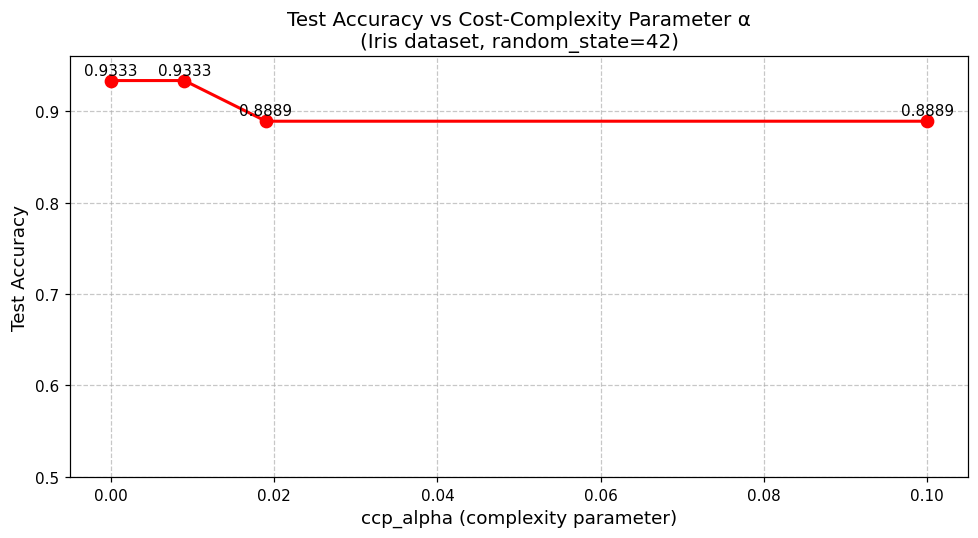

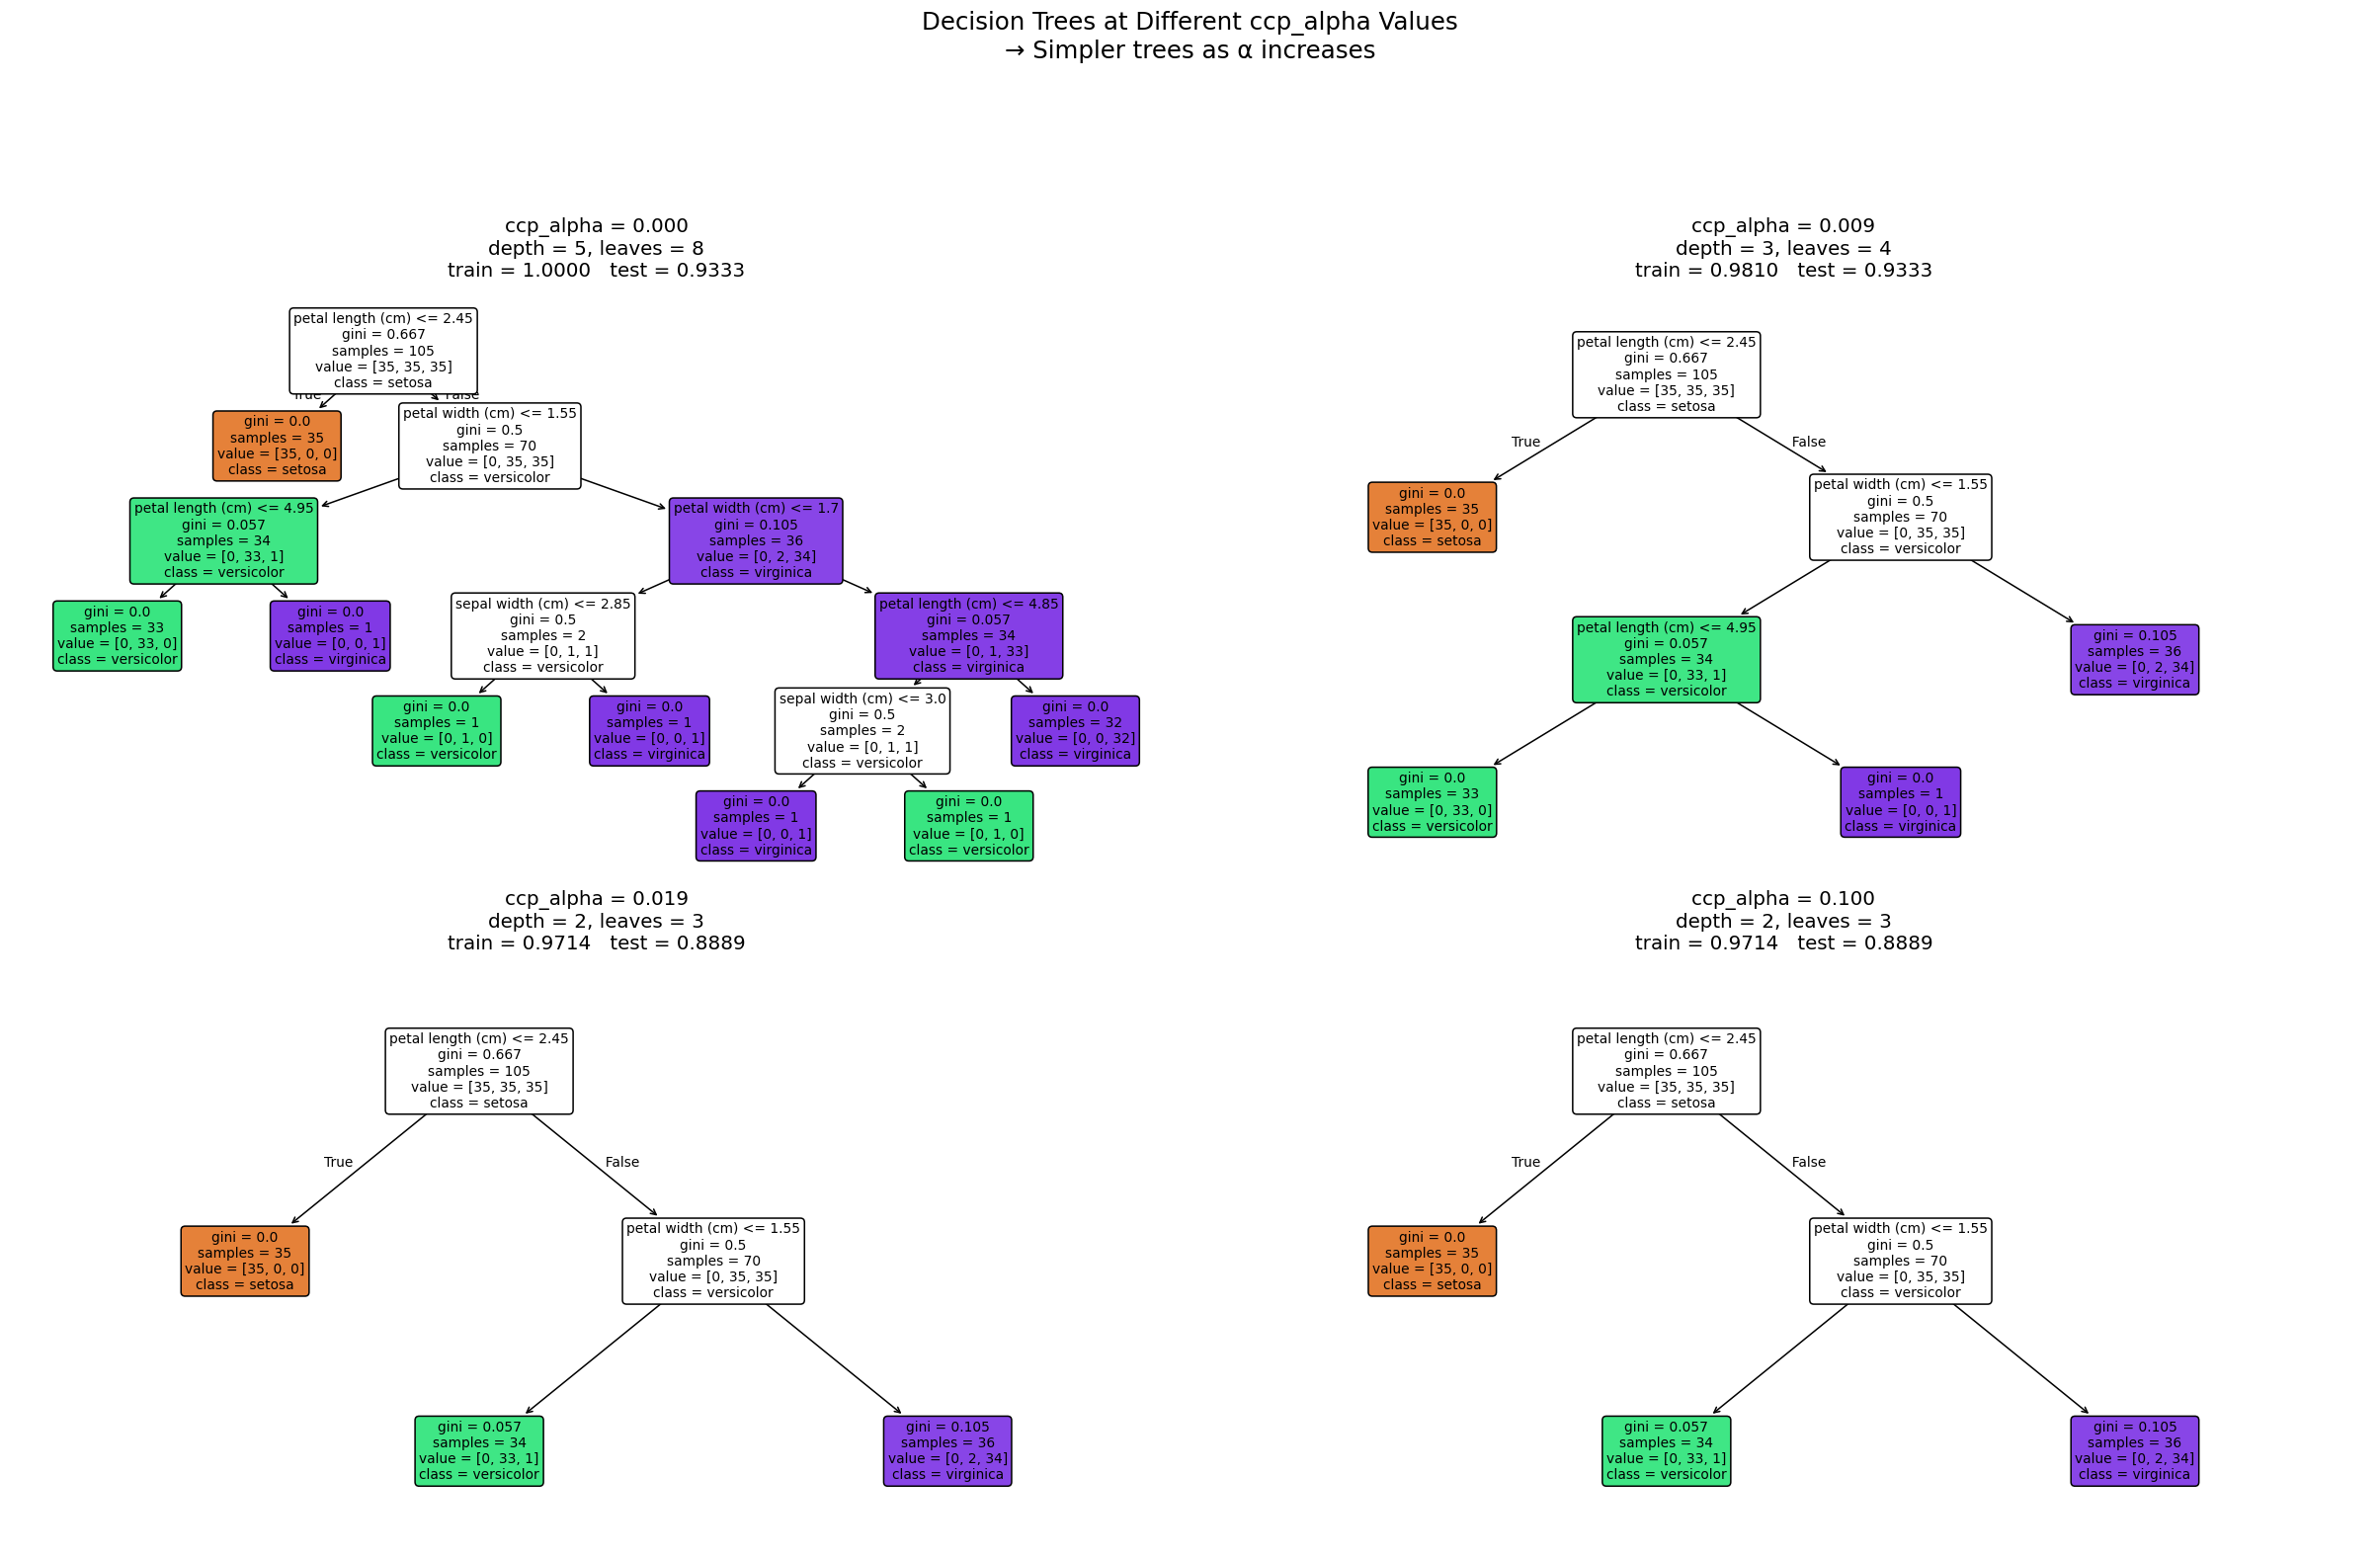


Done.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

# ── Data ─────────────────────────────────────────────────────────
iris = load_iris()
X, y = iris.data, iris.target
feature_names = iris.feature_names
class_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]} samples | Test: {X_test.shape[0]} samples\n")

# ── Train models for selected alpha values ───────────────────────
alphas_to_show = [0.000, 0.009, 0.019, 0.10]
trees = []
results = []
test_accuracies = []
ccp_alphas_used = []

for alpha in alphas_to_show:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    clf.fit(X_train, y_train)

    acc_tr = accuracy_score(y_train, clf.predict(X_train))
    acc_te = accuracy_score(y_test,  clf.predict(X_test))

    trees.append(clf)
    test_accuracies.append(acc_te)
    ccp_alphas_used.append(alpha)

    results.append({
        'alpha': alpha,
        'depth': clf.get_depth(),
        'leaves': clf.get_n_leaves(),
        'train_acc': acc_tr,
        'test_acc': acc_te
    })

# ── Summary table ────────────────────────────────────────────────
print("α      depth  leaves  train    test     comment")
print("-"*55)
for r in results:
    comment = "original / unpruned" if r['alpha'] == 0 else \
              "light pruning"       if r['alpha'] <= 0.01 else \
              "moderate pruning"
    print(f"{r['alpha']:.3f}   {r['depth']:5d}   {r['leaves']:6d}   "
          f"{r['train_acc']:.4f}  {r['test_acc']:.4f}  {comment}")

# ── Line plot: Test Accuracy vs ccp_alpha ────────────────────────
plt.figure(figsize=(9, 5), dpi=110)
plt.plot(ccp_alphas_used, test_accuracies, marker='o', color='red', linewidth=2, markersize=8)
plt.xlabel('ccp_alpha (complexity parameter)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Test Accuracy vs Cost-Complexity Parameter α\n(Iris dataset, random_state=42)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate each point with its accuracy value
for i, (x, y) in enumerate(zip(ccp_alphas_used, test_accuracies)):
    plt.text(x, y + 0.003, f'{y:.4f}', ha='center', va='bottom', fontsize=10)

plt.ylim(0.50, 0.96)  # adjust range based on your values
plt.tight_layout()
plt.show()

# ── Tree visualizations (improved layout) ────────────────────────
fig = plt.figure(figsize=(22, 14), dpi=110)
fig.subplots_adjust(hspace=0.55, wspace=0.25)

axes = fig.subplots(2, 2).ravel()

for i, (clf, res) in enumerate(zip(trees, results)):
    ax = axes[i]
    plot_tree(
        clf,
        ax=ax,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        fontsize=9,
        impurity=True
    )

    if i >= 2:
        plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    title = f"ccp_alpha = {res['alpha']:.3f}\n" \
            f"depth = {res['depth']}, leaves = {res['leaves']}\n" \
            f"train = {res['train_acc']:.4f}   test = {res['test_acc']:.4f}"
    ax.set_title(title, fontsize=13, pad=18)

plt.suptitle("Decision Trees at Different ccp_alpha Values\n"
             "→ Simpler trees as α increases", fontsize=16, y=1.04)
plt.tight_layout(rect=[0, 0.02, 1, 0.96])
plt.show()

print("\nDone.")

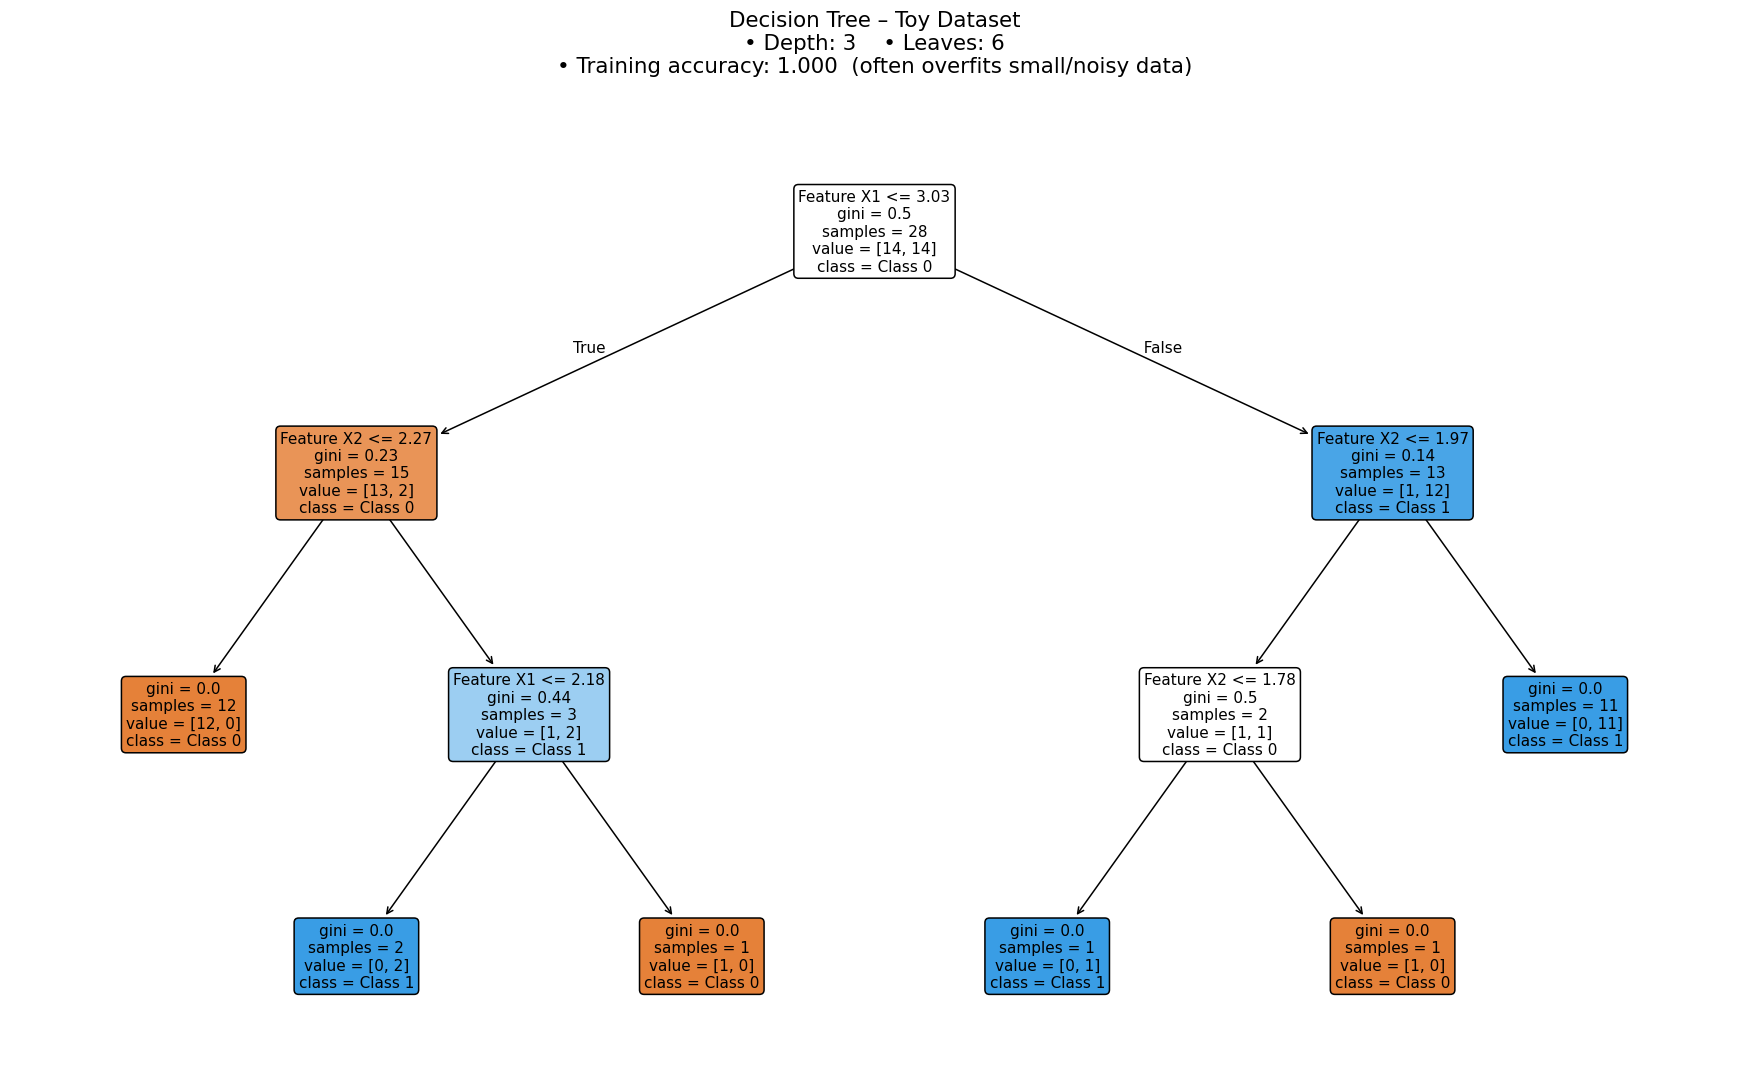

In [19]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# ── Plot the decision tree ────────────────────────────────────────────────
plt.figure(figsize=(16, 10), dpi=110)

# Main plot_tree call — only use documented parameters
plot_tree(
    clf,
    filled=True,                    # color nodes by class majority
    rounded=True,
    fontsize=10,                    # integer — controls ALL text size in nodes
    feature_names=["Feature X1", "Feature X2"],
    class_names=["Class 0", "Class 1"],
    impurity=True,                  # show Gini impurity
    node_ids=False,                 # optional: set True to show node numbers
    proportion=False,
    precision=2
)

# Title
plt.title(
    f"Decision Tree – Toy Dataset\n"
    f"• Depth: {clf.get_depth()}    • Leaves: {clf.get_n_leaves()}\n"
    f"• Training accuracy: {clf.score(X, y):.3f}  (often overfits small/noisy data)",
    fontsize=14,
    pad=25
)

plt.tight_layout()
plt.show()

# **Run This:**


STEP 1: Visualizing Full (Unpruned) Tree
✓ Full Tree visualization saved
  - Leaves: 20
  - Depth: 9
  - Training Accuracy: 100.00%

STEP 2: Visualizing Pruned Tree
✓ Pruned Tree visualization saved
  - Leaves: 5
  - Depth: 3
  - Training Accuracy: 94.00%

STEP 3: Creating Comparison Summary
✓ Comparison summary saved

FINAL SUMMARY
Full Tree     -> Leaves: 20 | Depth:  9 | Acc: 100.00%
Pruned Tree   -> Leaves:  5 | Depth:  3 | Acc: 94.00%
Reduction     -> 75.0% fewer leaves
Depth reduced -> 6 level(s)

✓ All visualizations complete!
  Files saved:
  1. full_tree.png
  2. pruned_tree.png
  3. comparison_summary.png


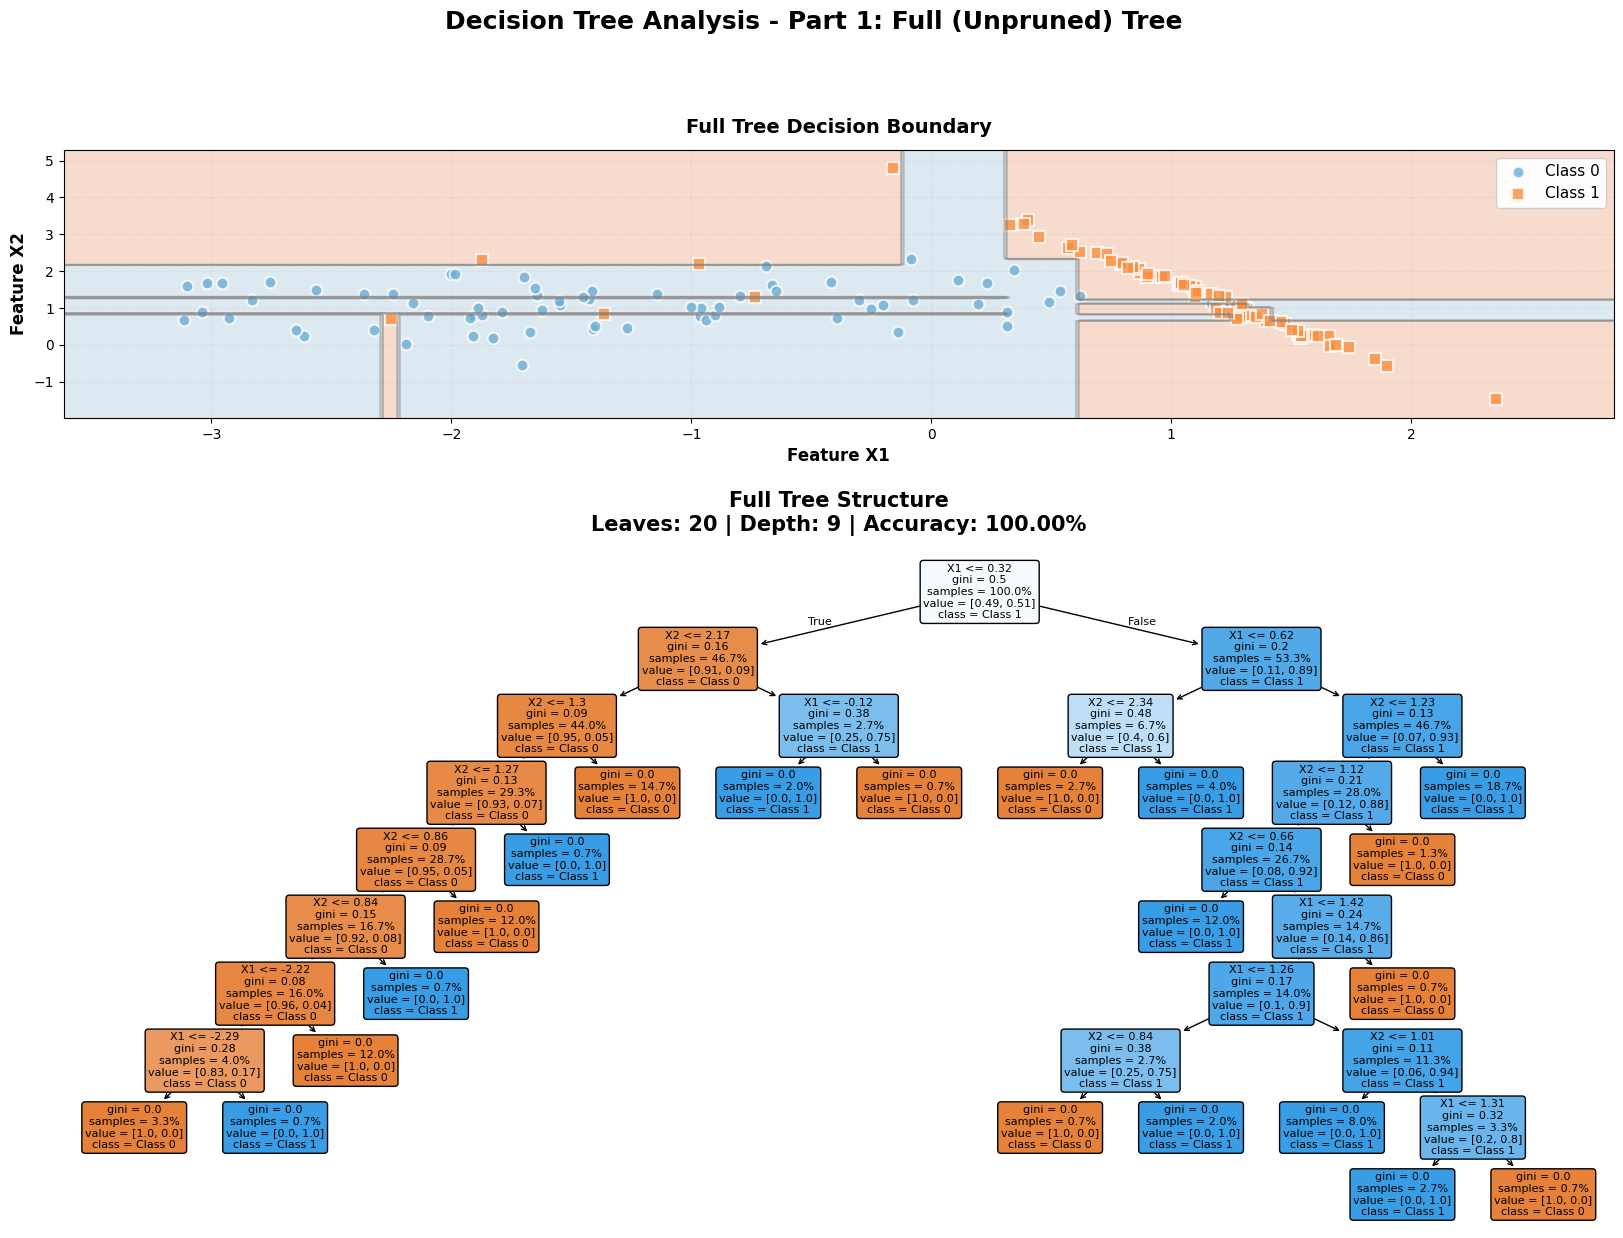

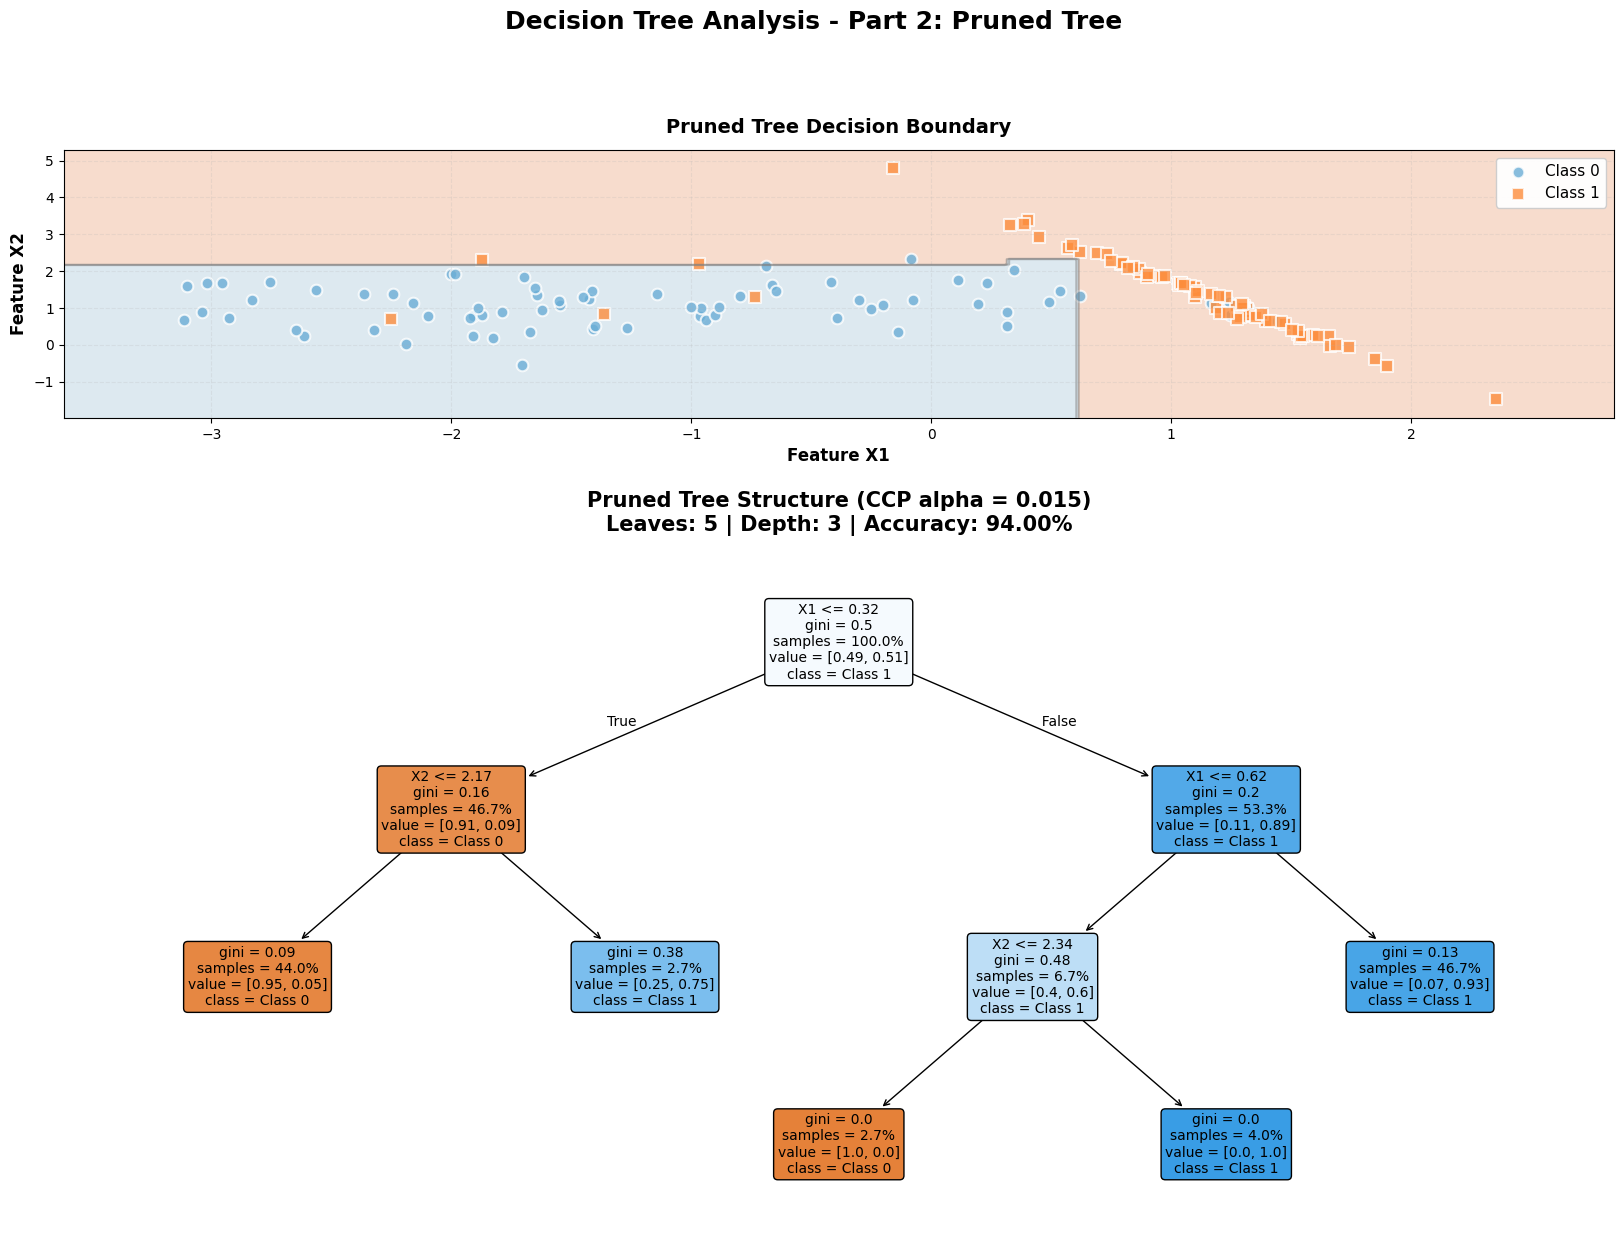

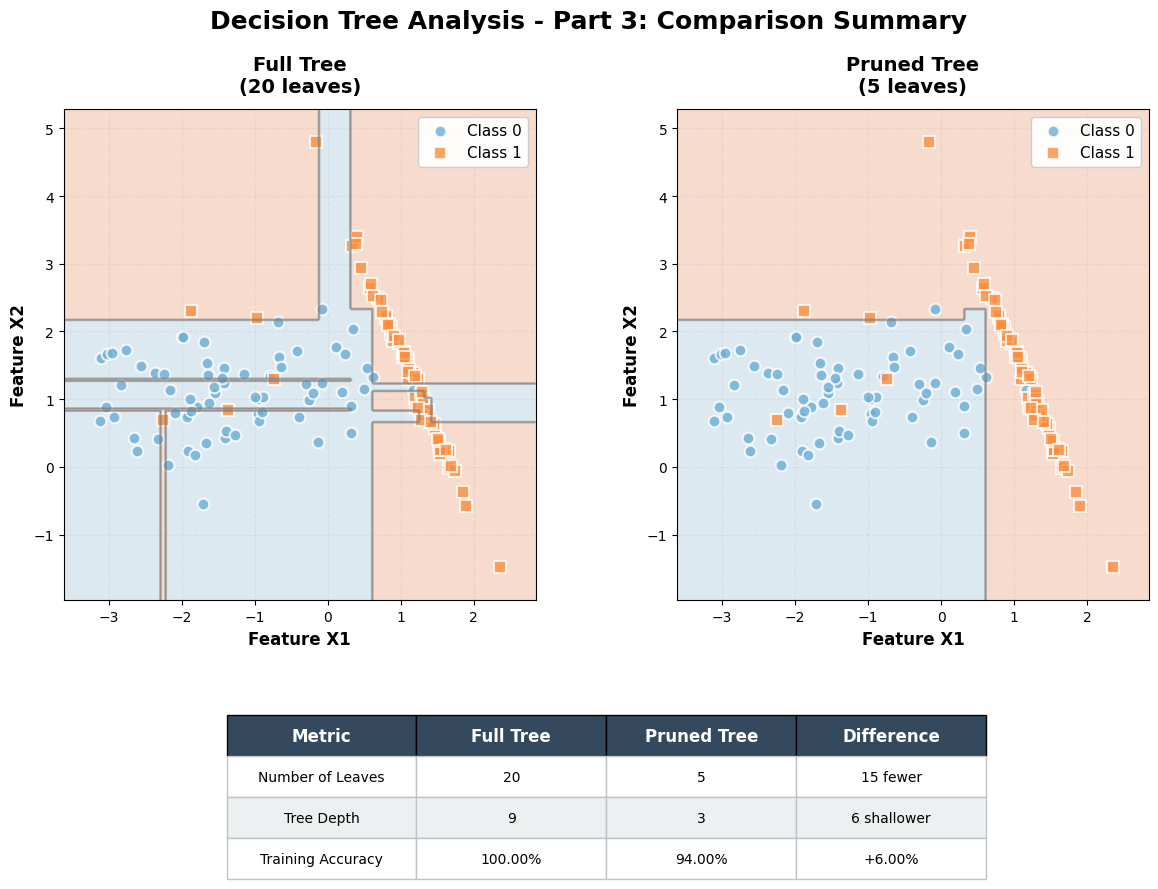

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import make_classification

# ────────────────────────────────────────────────────────────────
#  Create a small toy dataset (so you can run this standalone)
# ────────────────────────────────────────────────────────────────
np.random.seed(42)
X, y = make_classification(
    n_samples=150,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.08,           # some label noise
    class_sep=1.2,
    random_state=42
)

# ────────────────────────────────────────────────────────────────
#  Full (unpruned) tree
# ────────────────────────────────────────────────────────────────
clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,           # let it grow fully
    min_samples_leaf=1,
    random_state=42
)
clf.fit(X, y)

# ────────────────────────────────────────────────────────────────
#  Pruned tree using cost-complexity pruning (CCP)
# ────────────────────────────────────────────────────────────────
clf_pruned = DecisionTreeClassifier(
    criterion='gini',
    ccp_alpha=0.015,          # ← tune this value (higher = more pruning)
    random_state=42
)
clf_pruned.fit(X, y)

# Color scheme
color_palette = {
    'class0': '#6baed6',  # soft blue
    'class1': '#fd8d3c',  # soft orange
    'bg': '#f7f7f7'
}

# ────────────────────────────────────────────────────────────────
#  Helper function for decision boundary
# ────────────────────────────────────────────────────────────────
def plot_decision_boundary(ax, clf, X, y, title):
    """Plot decision boundary with data points"""
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.25, cmap='RdYlBu_r', levels=1)
    ax.contour(xx, yy, Z, colors='gray', linewidths=1.5, levels=1, alpha=0.5)

    scatter = ax.scatter(X[y==0, 0], X[y==0, 1], c=color_palette['class0'],
                        s=70, edgecolors='white', linewidths=1.5,
                        label='Class 0', alpha=0.8, marker='o')
    scatter = ax.scatter(X[y==1, 0], X[y==1, 1], c=color_palette['class1'],
                        s=70, edgecolors='white', linewidths=1.5,
                        label='Class 1', alpha=0.8, marker='s')

    ax.set_xlabel('Feature X1', fontsize=12, fontweight='bold')
    ax.set_ylabel('Feature X2', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=12)
    ax.legend(loc='upper right', framealpha=0.95, fontsize=11)
    ax.grid(True, alpha=0.2, linestyle='--')
    ax.set_facecolor(color_palette['bg'])

# ────────────────────────────────────────────────────────────────
#  FIGURE 1: Full Tree
# ────────────────────────────────────────────────────────────────
print("\n" + "="*60)
print("STEP 1: Visualizing Full (Unpruned) Tree")
print("="*60)

fig1 = plt.figure(figsize=(20, 14), facecolor='white')
gs1 = fig1.add_gridspec(2, 1, height_ratios=[1, 2.5], hspace=0.3)

# Decision boundary for full tree
ax_data1 = fig1.add_subplot(gs1[0])
plot_decision_boundary(ax_data1, clf, X, y,
                       'Full Tree Decision Boundary')

# Tree structure for full tree
ax_tree1 = fig1.add_subplot(gs1[1])
plot_tree(
    clf,
    ax=ax_tree1,
    filled=True,
    rounded=True,
    fontsize=8,
    feature_names=["X1", "X2"],
    class_names=["Class 0", "Class 1"],
    impurity=True,
    proportion=True,
    precision=2
)
ax_tree1.set_title(
    f"Full Tree Structure\n"
    f"Leaves: {clf.get_n_leaves()} | "
    f"Depth: {clf.get_depth()} | "
    f"Accuracy: {clf.score(X, y):.2%}",
    fontsize=15,
    fontweight='bold',
    pad=20
)

fig1.suptitle(
    "Decision Tree Analysis - Part 1: Full (Unpruned) Tree",
    fontsize=18,
    fontweight='bold',
    y=0.98
)

plt.savefig('/home/full_tree.png', dpi=150, bbox_inches='tight')
print(f"✓ Full Tree visualization saved")
print(f"  - Leaves: {clf.get_n_leaves()}")
print(f"  - Depth: {clf.get_depth()}")
print(f"  - Training Accuracy: {clf.score(X, y):.2%}")

# ────────────────────────────────────────────────────────────────
#  FIGURE 2: Pruned Tree
# ────────────────────────────────────────────────────────────────
print("\n" + "="*60)
print("STEP 2: Visualizing Pruned Tree")
print("="*60)

fig2 = plt.figure(figsize=(20, 14), facecolor='white')
gs2 = fig2.add_gridspec(2, 1, height_ratios=[1, 2.5], hspace=0.3)

# Decision boundary for pruned tree
ax_data2 = fig2.add_subplot(gs2[0])
plot_decision_boundary(ax_data2, clf_pruned, X, y,
                       'Pruned Tree Decision Boundary')

# Tree structure for pruned tree
ax_tree2 = fig2.add_subplot(gs2[1])
plot_tree(
    clf_pruned,
    ax=ax_tree2,
    filled=True,
    rounded=True,
    fontsize=10,
    feature_names=["X1", "X2"],
    class_names=["Class 0", "Class 1"],
    impurity=True,
    proportion=True,
    precision=2
)
ax_tree2.set_title(
    f"Pruned Tree Structure (CCP alpha = {clf_pruned.ccp_alpha})\n"
    f"Leaves: {clf_pruned.get_n_leaves()} | "
    f"Depth: {clf_pruned.get_depth()} | "
    f"Accuracy: {clf_pruned.score(X, y):.2%}",
    fontsize=15,
    fontweight='bold',
    pad=20
)

fig2.suptitle(
    "Decision Tree Analysis - Part 2: Pruned Tree",
    fontsize=18,
    fontweight='bold',
    y=0.98
)

plt.savefig('/home/pruned_tree.png', dpi=150, bbox_inches='tight')
print(f"✓ Pruned Tree visualization saved")
print(f"  - Leaves: {clf_pruned.get_n_leaves()}")
print(f"  - Depth: {clf_pruned.get_depth()}")
print(f"  - Training Accuracy: {clf_pruned.score(X, y):.2%}")

# ────────────────────────────────────────────────────────────────
#  FIGURE 3: Comparison Summary
# ────────────────────────────────────────────────────────────────
print("\n" + "="*60)
print("STEP 3: Creating Comparison Summary")
print("="*60)

fig3 = plt.figure(figsize=(14, 10), facecolor='white')
gs3 = fig3.add_gridspec(2, 2, height_ratios=[3, 1], hspace=0.35, wspace=0.3)

# Side-by-side decision boundaries
ax_comp1 = fig3.add_subplot(gs3[0, 0])
plot_decision_boundary(ax_comp1, clf, X, y,
                       f'Full Tree\n({clf.get_n_leaves()} leaves)')

ax_comp2 = fig3.add_subplot(gs3[0, 1])
plot_decision_boundary(ax_comp2, clf_pruned, X, y,
                       f'Pruned Tree\n({clf_pruned.get_n_leaves()} leaves)')

# Metrics table
ax_metrics = fig3.add_subplot(gs3[1, :])
ax_metrics.axis('off')

metrics_data = [
    ['Metric', 'Full Tree', 'Pruned Tree', 'Difference'],
    ['Number of Leaves', f'{clf.get_n_leaves()}', f'{clf_pruned.get_n_leaves()}',
     f'{clf.get_n_leaves() - clf_pruned.get_n_leaves()} fewer'],
    ['Tree Depth', f'{clf.get_depth()}', f'{clf_pruned.get_depth()}',
     f'{clf.get_depth() - clf_pruned.get_depth()} shallower'],
    ['Training Accuracy', f'{clf.score(X, y):.2%}', f'{clf_pruned.score(X, y):.2%}',
     f'{(clf.score(X, y) - clf_pruned.score(X, y))*100:+.2f}%'],
]

table = ax_metrics.table(cellText=metrics_data, cellLoc='center',
                         loc='center', bbox=[0.15, 0.0, 0.7, 1.0])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style the header row
for i in range(4):
    cell = table[(0, i)]
    cell.set_facecolor('#34495e')
    cell.set_text_props(weight='bold', color='white', size=12)

# Style data rows with alternating colors
for i in range(1, 4):
    for j in range(4):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#ecf0f1')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('#bdc3c7')
        cell.set_text_props(size=10)

fig3.suptitle(
    "Decision Tree Analysis - Part 3: Comparison Summary",
    fontsize=18,
    fontweight='bold',
    y=0.98
)

plt.savefig('/home/comparison_summary.png', dpi=150, bbox_inches='tight')
print(f"✓ Comparison summary saved")

# ────────────────────────────────────────────────────────────────
#  Print final summary statistics
# ────────────────────────────────────────────────────────────────
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Full Tree     -> Leaves: {clf.get_n_leaves():2d} | Depth: {clf.get_depth():2d} | Acc: {clf.score(X, y):.2%}")
print(f"Pruned Tree   -> Leaves: {clf_pruned.get_n_leaves():2d} | Depth: {clf_pruned.get_depth():2d} | Acc: {clf_pruned.score(X, y):.2%}")
print(f"Reduction     -> {((clf.get_n_leaves() - clf_pruned.get_n_leaves())/clf.get_n_leaves()*100):.1f}% fewer leaves")
print(f"Depth reduced -> {clf.get_depth() - clf_pruned.get_depth()} level(s)")
print("="*60)

print("\n✓ All visualizations complete!")
print("  Files saved:")
print("  1. full_tree.png")
print("  2. pruned_tree.png")
print("  3. comparison_summary.png")

plt.show()